# Collaborative filtering using Restricted Boltzman Machine

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Loading the data

In [2]:
rating_df = pd.read_csv('./data/ratings.csv')
movies_df = pd.read_csv('./data/movies.csv')

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
len(movies_df)

9125

In [5]:
rating_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
user_ratings_df = rating_df.pivot(index="movieId",columns="userId",values='rating')
user_ratings_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
normalized_usr_rating = user_ratings_df.fillna(0)/5.0
normalized_usr_rating.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.8,0.0,...,0.0,0.8,0.7,0.0,0.0,0.0,0.0,0.0,0.8,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
matrix = normalized_usr_rating.values
matrix[0:5]

array([[0. , 0. , 0. , ..., 0. , 0.8, 1. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

## Model Implementation

In [9]:
hiddenunits = 20
visibleunits = len(user_ratings_df.columns)
hb = tf.placeholder("float",[hiddenunits])
vb = tf.placeholder("float",[visibleunits])
W = tf.placeholder("float",[visibleunits,hiddenunits])

In [10]:
v0 = tf.placeholder("float",[None,visibleunits])
_h0 = tf.nn.sigmoid(tf.matmul(v0,W)+hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

In [11]:
#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

In [12]:
err = v0 - v1
err_sum = tf.reduce_mean(err * err)

In [13]:
#Current weight
cur_w = np.zeros([visibleunits, hiddenunits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleunits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenunits], np.float32)
#Previous weight
prv_w = np.zeros([visibleunits, hiddenunits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleunits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenunits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

0.023991872
0.020551106
0.019385107
0.018912151
0.018549658
0.01827043
0.018264959
0.01782969
0.017736068
0.01758308
0.017304016
0.01730768
0.017313223
0.017403001
0.017377082
0.017393436
0.017309044
0.017189296
0.017235812
0.017148457
0.017273087
0.017126689
0.017116537
0.017138146
0.017264126


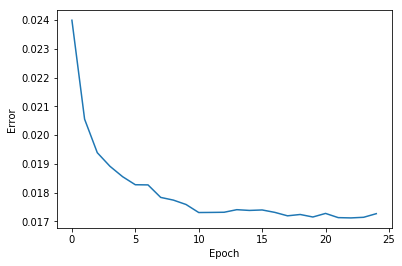

In [14]:
epochs = 25
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(matrix), batchsize), range(batchsize, len(matrix), batchsize)):
        batch = matrix[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_hb
    errors.append(sess.run(err_sum, feed_dict={v0: matrix, W: cur_w, vb: cur_vb, hb: cur_hb}))
    print (errors[-1])
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

## Recommendation

In [15]:
mock_user_id = 215

In [16]:
inputUser = matrix[mock_user_id-1].reshape(1, -1)
inputUser[0:5]

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.8, 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. 

In [17]:
inputUser.shape

(1, 671)

In [18]:
#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})
print(rec.shape)

(1, 671)


In [19]:
rec.shape

(1, 671)

In [20]:
rec[0][0:576]

array([0.0007819 , 0.00279377, 0.00315786, 0.01155885, 0.00357263,
       0.00204669, 0.00290691, 0.00554217, 0.00224677, 0.00330778,
       0.00237841, 0.00428949, 0.00224336, 0.00109823, 0.09853011,
       0.00220871, 0.01989252, 0.00199645, 0.01249465, 0.00672332,
       0.00353728, 0.0096882 , 0.02883684, 0.00128882, 0.00132053,
       0.00389021, 0.00120954, 0.00127307, 0.00144735, 0.03344664,
       0.00270535, 0.00200515, 0.00902914, 0.00645703, 0.00070066,
       0.00460945, 0.00231898, 0.00979131, 0.00504125, 0.00101236,
       0.02118942, 0.00186877, 0.00674937, 0.00118671, 0.00138042,
       0.00296186, 0.00197667, 0.0255984 , 0.00563632, 0.00167862,
       0.00230448, 0.00716628, 0.00304684, 0.00314441, 0.00194182,
       0.02775488, 0.0063579 , 0.00363381, 0.00394328, 0.00337894,
       0.00477772, 0.00133346, 0.00497599, 0.0011526 , 0.00105608,
       0.00276219, 0.00646954, 0.00654524, 0.00412905, 0.00596295,
       0.00221367, 0.0024561 , 0.09017987, 0.00258938, 0.00681

In [22]:
movies_df.shape

(9125, 3)

In [23]:
movies_df[movies_df['movieId'].isin(user_ratings_df.columns)]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


In [24]:
scored_movies_df_mock = movies_df[movies_df['movieId'].isin(user_ratings_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0][0:len(scored_movies_df_mock)])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,movieId,title,genres,RecommendationScore
14,15,Cutthroat Island (1995),Action|Adventure|Romance,0.098530
546,620,Scream of Stone (Cerro Torre: Schrei aus Stein...,Drama,0.095717
72,78,"Crossing Guard, The (1995)",Action|Crime|Drama|Thriller,0.090180
379,429,Cabin Boy (1994),Comedy,0.058363
293,328,Tales from the Crypt Presents: Demon Knight (1...,Horror|Thriller,0.048925
212,240,Hideaway (1995),Thriller,0.046404
451,505,North (1994),Comedy,0.043513
387,438,"Cowboy Way, The (1994)",Action|Comedy|Drama,0.040032
261,291,Poison Ivy II (1996),Drama|Thriller,0.038866
310,345,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama,0.036573


In [25]:
movies_df_mock = rating_df[rating_df['userId'] == mock_user_id]
movies_df_mock.head() 

,userId,movieId,rating,timestamp
30390,215,1,3.0,860559708
30391,215,6,3.0,860559733
30392,215,86,3.0,860559829
30393,215,111,4.0,860560442
30394,215,260,3.0,860559756


In [26]:
#Merging movies_df with ratings_df by MovieID
merged_df_mock = scored_movies_df_mock.merge(movies_df_mock, on='movieId', how='outer')

In [27]:
merged_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,movieId,title,genres,RecommendationScore,userId,rating,timestamp
14,15,Cutthroat Island (1995),Action|Adventure|Romance,0.098530,NaN,NaN,NaN
546,620,Scream of Stone (Cerro Torre: Schrei aus Stein...,Drama,0.095717,NaN,NaN,NaN
72,78,"Crossing Guard, The (1995)",Action|Crime|Drama|Thriller,0.090180,NaN,NaN,NaN
379,429,Cabin Boy (1994),Comedy,0.058363,NaN,NaN,NaN
293,328,Tales from the Crypt Presents: Demon Knight (1...,Horror|Thriller,0.048925,NaN,NaN,NaN
212,240,Hideaway (1995),Thriller,0.046404,NaN,NaN,NaN
451,505,North (1994),Comedy,0.043513,NaN,NaN,NaN
387,438,"Cowboy Way, The (1994)",Action|Comedy|Drama,0.040032,NaN,NaN,NaN
261,291,Poison Ivy II (1996),Drama|Thriller,0.038866,NaN,NaN,NaN
310,345,"Adventures of Priscilla, Queen of the Desert, ...",Comedy|Drama,0.036573,NaN,NaN,NaN
